# Project: Toxic Comment Filter

Costruire un modello in grado di filtrare i commenti degli utenti in base al grado di dannosità del linguaggio:
1. Preprocessare il testo eliminando l'insieme di token che non danno contributo significativo a livello semantico
2. Trasformare il corpus testuale in sequenze
3. Costruire un modello di Deep Learning comprendente dei layer ricorrenti per un task di classificazione multilabel
4. In prediction time, il modello deve ritornare un vettore contenente un 1 o uno 0 in corrispondenza di ogni label presente nel dataset (toxic,	severe_toxic,	obscene,	threat,	insult,	identity_hate). In questo modo, un commento non dannoso sarà classificato da un vettore di soli 0 [0,0,0,0,0,0]. Al contrario, un commento pericoloso presenterà almeno un 1 tra le 6 labels.

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Input, GRU, Bidirectional, Embedding, Dense, TextVectorization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import re
import nltk
from nltk.corpus import stopwords

RANDOM_SEED = 42

In [2]:
BASE_URL = "https://s3.eu-west-3.amazonaws.com/profession.ai/datasets/"
df = pd.read_csv(BASE_URL+"Filter_Toxic_Comments_dataset.csv")

In [3]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


In [4]:
#BLACK HUMOR ALERT
# df[df['sum_injurious']==6]

## Preprocessing
Provided dataset contains a lot of noise, meaning that there are a lot of words and punctuation that aren't useful for classification.

In text classification is crucial removing such words and punctuation, since the model could learn them, getting confused about text context.

In this project the preprocessing consists in 3 steps:
1. Lower text (Uppercase text is useless to catch the meaning of the phrase).
1. Remove punctuation and other symbols that are imported from "copy-paste" operation while building dataset: since comments are extracted from a web blog, some of them have symbols and numbers coming from a logging-like system (like timestamps, ip addresses or URLs). Again these terms are noise regarding the context.
1. Remove common english [stopwords](https://kavita-ganesan.com/what-are-stop-words/): these words are commonly used in written or oral communication (since they're fundamental for grammar rules), but they have low discriminating power regarding the text meaning (in a classification task). Examples of stopwords are prepositions and coordinating conjunctions.

Preprocessing can be considered a data-cleaning phase, where unnecessary words are filtered from corpus. To accomplish it, the nltk lib is used, in conjucntion with `re` python package.

Notice how the preprocessing is data-independent, i.e. there isn't a transformer that is fitted on data (like in numerical normalization for example).

In [5]:
#download common stopwords list using nltk utility
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
def clean_text(text):
    """
    Utility custom function to clean a single text string.
    Text is cleaned from punctuation, english common stopwords and
    is lowered.

    Parameters:
    - text (string): English text to be cleaned

    Return:
    Cleaned text as string.
    """
    # lowercase
    text = text.lower()

    # remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>+', '', text)

    # split text using any whitespace separator (including \n)
    words = text.split()

    # remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    #join words in a string
    return ' '.join(words)

Apply custom preprocessing function and collect new records in a new dataframe column.

In [7]:
df["comment_text_clean"] = df["comment_text"].apply(clean_text)

df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious,comment_text_clean
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,explanation edits made username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,daww matches background colour im seemingly st...
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,hey man im really trying edit war guy constant...
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,cant make real suggestions improvement wondere...
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,sir hero chance remember page thats


In [8]:
raw_len = df["comment_text"].apply(len)
clean_len = df["comment_text_clean"].apply(len)

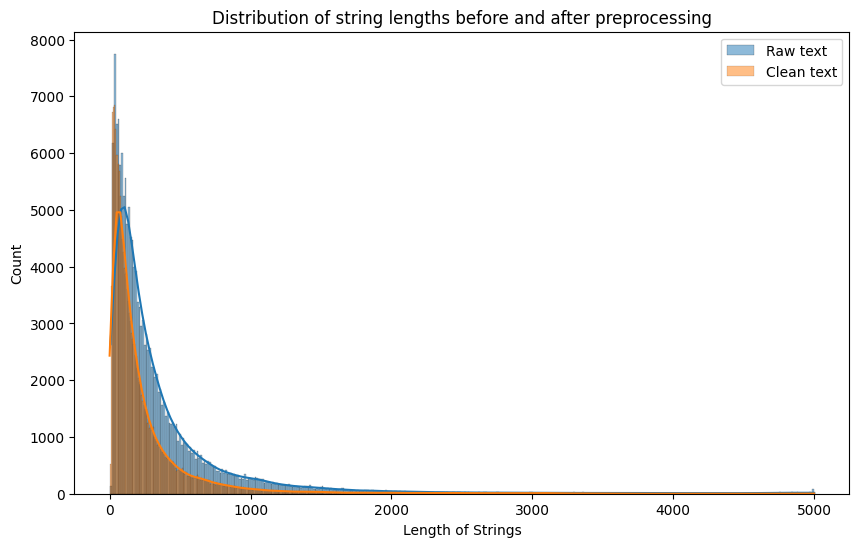

In [9]:
plt.figure(figsize=(10,6))
sns.histplot(x=raw_len, label="Raw text", kde=True)
sns.histplot(x=clean_len, label="Clean text", kde=True)
plt.legend()
plt.xlabel('Length of Strings')
plt.title('Distribution of string lengths before and after preprocessing')
plt.show()

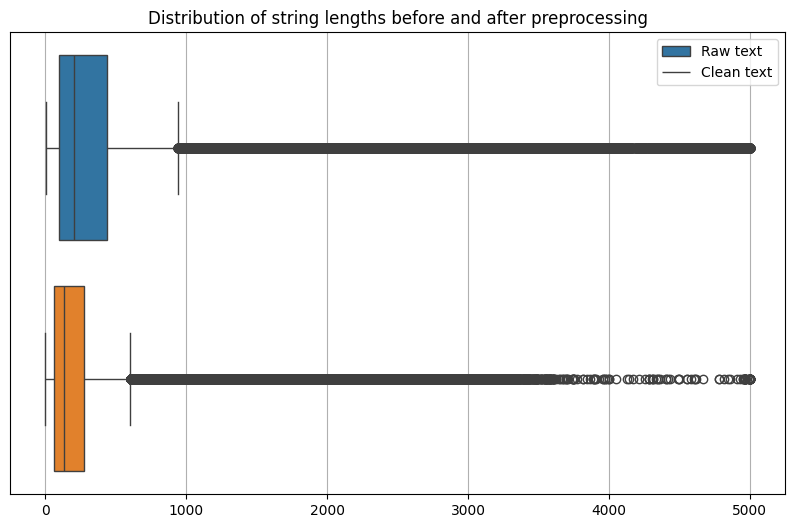

In [10]:
plt.figure(figsize=(10,6))
sns.boxplot(data=[raw_len.values, clean_len.values], orient="h")
plt.legend(["Raw text","Clean text"])
plt.title('Distribution of string lengths before and after preprocessing')
plt.yticks([])
plt.gca().grid(True)
plt.show()

In [11]:
print("Text lenght summary stats:")
pd.DataFrame([raw_len.describe(),clean_len.describe()])

Text lenght summary stats:


,count,mean,std,min,25%,50%,75%,max
comment_text,159571.0,394.073221,590.720282,6.0,96.0,205.0,435.0,5000.0
comment_text_clean,159571.0,254.817862,396.301048,0.0,60.0,131.0,278.0,5000.0


Cose da notare:
1. Mediana diversa (e anche parecchio), stessa cosa per la media.
Quindi nel complesso la pulizia rimuove un bel po' di parole e quindi creerà un modello migliore (vocabolario meno dispersivo).
1. Valore minimo dopo pulizia: lunghezza = 0 significa che non ho una vera e propria frase -> rimuovere gli item con lunghezza = 0 (se sono tanti... Se sono pochi volendo possono restare).

In [12]:
# (clean_len == 0).value_counts()

In [13]:
df = df[clean_len != 0]

#check
print(df.shape)

#reassign utils variables
raw_len = df["comment_text"].apply(len)
clean_len = df["comment_text_clean"].apply(len)

(159552, 9)


In [14]:
float(np.median(clean_len))

131.0

In base a quanto scritto nella cella precedente, bisogna fare un passo di preprocessing anche per le classi.
Nel dataframe di partenza ho 1 colonna per ogni classe, mentre qui devo accorpare queste colonne in una singola colonna contenente una lista.


## Dataset split
Here `train_test_split` from sklearn is used twice to get train, validation and test set. They will be used during model training.

In [15]:
df_train_val, df_test = train_test_split(df, test_size=0.2,
                                         random_state=RANDOM_SEED)

df_train, df_valid = train_test_split(df_train_val, test_size=0.25,
                                   random_state=RANDOM_SEED)
#60 % train, 20 % valid, 20% test

#check
print(f"Train df shape: {df_train.shape}")
print(f"Test df shape: {df_test.shape}")
print(f"Valid df shape: {df_valid.shape}")


Train df shape: (95730, 9)
Test df shape: (31911, 9)
Valid df shape: (31911, 9)


## SMOTE

Before moving on, one should check classes distribution.

In similar tasks quite often the dataset in unbalanced, and it's a problem during model fitting, since it could lead to overfitting.

### TODO: Mettere qualche link di spiegazione

To explore classes distribution we can use "sum_injurous" feature, that is a summary of possible records' classes: if this feature is 0, the record belongs to "neutral" class, in all other cases it belongs at least to one "toxic" class.

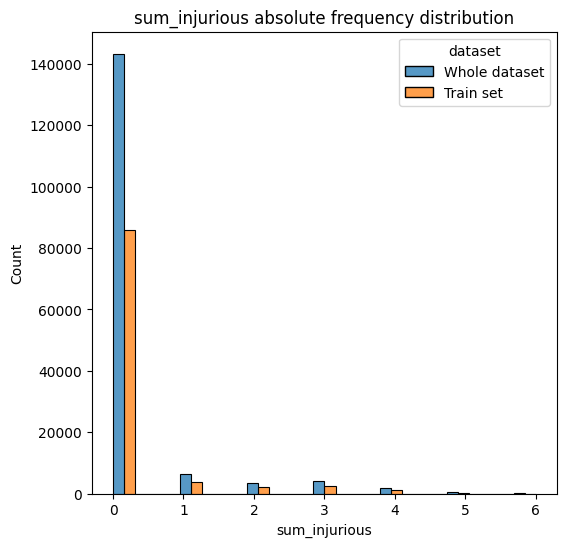

In [16]:
#temporary workaround to get a legend in histplot
df["dataset"] = 'Whole dataset'
df_train["dataset"] = 'Train set'
tmp = pd.concat([df,df_train])

#plot
plt.figure(figsize=(6,6))
sns.histplot(data=tmp, x="sum_injurious",
             hue="dataset", multiple="dodge")
plt.title("sum_injurious absolute frequency distribution")
plt.show()

#back to original dataframes
df.drop(["dataset"], axis=1, inplace=True)
df_train.drop(["dataset"], axis=1, inplace=True)

As one can sees, dataset is very unbalaced towards "neutral" class (i.e. sum_injurious = 0), meaning that most of comments aren't toxic at all.

This unbalace is present in train set too.

This unbalance must be handled somehow.

In [17]:
most_frequent_class_size = (df_train["sum_injurious"] == 0).sum()

for i in np.unique(df_train["sum_injurious"]): #[0,6]
    subset = df_train[df_train["sum_injurious"] == i]
    num_samples_class = len(subset)
    difference = most_frequent_class_size - num_samples_class

    if difference == 0:
        continue

    oversample_values = []
    print(i)
    print(most_frequent_class_size)
    print(num_samples_class)
    print(difference)
    print((df_train["sum_injurious"] == 0).shape)
    print(subset.shape)
    print(difference/num_samples_class)
    for _ in np.arange(np.floor(difference/num_samples_class)):
        oversample_values.append(subset)

    oversample_values_df = pd.concat(oversample_values,ignore_index=True)
    df_train = pd.concat([df_train,oversample_values_df],ignore_index=True)


print(df_train.shape)

1
85949
3857
82092
(95730,)
(3857, 9)
21.28389940368162
2
85949
2097
83852
(176727,)
(2097, 9)
39.986647591797805
3
85949
2501
83448
(258510,)
(2501, 9)
33.36585365853659
4
85949
1074
84875
(341043,)
(1074, 9)
79.0270018621974
5
85949
228
85721
(425889,)
(228, 9)
375.969298245614
6
85949
24
85925
(511389,)
(24, 9)
3580.2083333333335
(597309, 9)


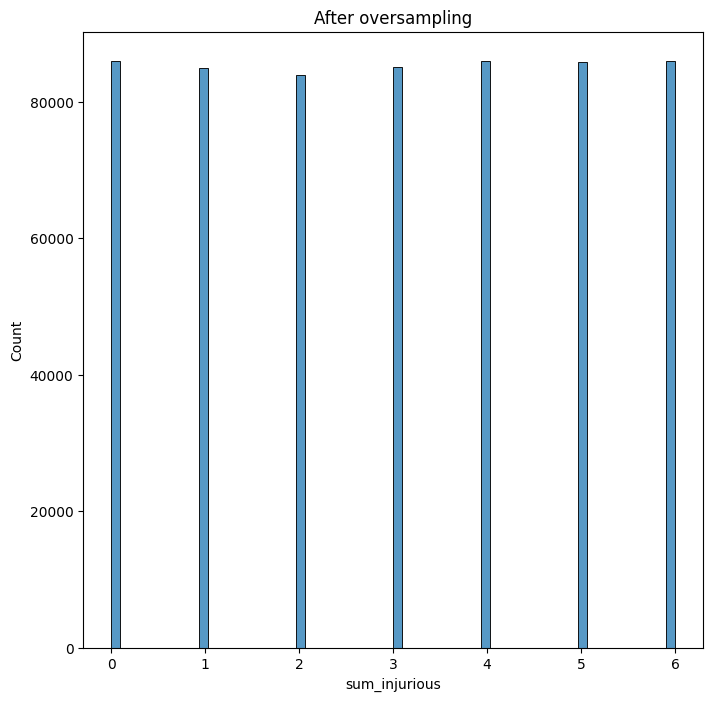

In [18]:
plt.figure(figsize=(8,8))
sns.histplot(data=df_train,x="sum_injurious")
plt.title("After oversampling")
plt.show()

In [19]:
#Get numpy ndarrays from dataframes
X_train = df_train["comment_text_clean"].values
y_train = df_train.drop(["comment_text","sum_injurious",\
                         "comment_text_clean"],
                        axis=1).values

X_test = df_test["comment_text_clean"].values
y_test = df_test.drop(["comment_text","sum_injurious",\
                         "comment_text_clean"],
                        axis=1).values

X_valid = df_valid["comment_text_clean"].values
y_valid = df_valid.drop(["comment_text","sum_injurious",\
                         "comment_text_clean"],
                        axis=1).values

## Model

In [20]:
clear_session()

max_tokens = 10000 # Numero massimo di token nel vocabolario
max_len = 280 # Lunghezza massima delle sequenze di input - usare 3° interquartile di lunghezze di sequenza
embedding_dim = 256 #dimensione embedding
rnn_dim = 128 #dimensione layer RNN

# input_layer = Input(shape = (maxlen_seq,), name="Input_layer")
input_layer = Input(shape = (1,),dtype='string', name="Input_layer")

vectorize_layer = TextVectorization(max_tokens=max_tokens, output_mode='int', output_sequence_length=max_len)
vectorize_layer.adapt(X_train)
tmp = vectorize_layer(input_layer)

embedding_layer = Embedding(max_tokens, embedding_dim, name ="Embedding_layer")(tmp)
recursive_layer = Bidirectional(GRU(rnn_dim, return_sequences=False,name="GRU"),name="Bidirectional_layer")(embedding_layer)
dense_layer = Dense(1024, activation = 'relu', name ='Dense')(recursive_layer)
output_layer = Dense(6,activation='sigmoid', name = "Sigmoid_layer")(dense_layer)

model = Model(inputs=input_layer, outputs=output_layer)

# plot_file = 'model_plot_new.png'
# plot_model(model, to_file=plot_file, show_shapes=True,
#            show_layer_names=True)

In [21]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['F1Score'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 280)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Embedding_layer (Embedding)          │ (None, 280, 256)            │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Bidirectional_layer (Bidirectional)  │ (None, 256)                 │         296,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense (Dense)                        │ (None, 1024)                │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Sigmoid_layer (Dense)                │ (None, 6)                   │           6,150 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,125,766 (11.92 MB)

 Trainable params: 3,125,766 (11.92 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
%%time
history = model.fit(X_train,y_train,epochs=10,batch_size=1024,validation_data=(X_valid, y_valid))

Epoch 1/10
584/584 ━━━━━━━━━━━━━━━━━━━━ 165s 274ms/step - F1Score: 0.1843 - loss: 0.2194 - val_F1Score: 0.0722 - val_loss: 0.1273
Epoch 2/10
584/584 ━━━━━━━━━━━━━━━━━━━━ 162s 277ms/step - F1Score: 0.3485 - loss: 0.0210 - val_F1Score: 0.1000 - val_loss: 0.1785
Epoch 3/10
584/584 ━━━━━━━━━━━━━━━━━━━━ 202s 278ms/step - F1Score: 0.4731 - loss: 0.0088 - val_F1Score: 0.1319 - val_loss: 0.2106
Epoch 4/10
584/584 ━━━━━━━━━━━━━━━━━━━━ 165s 283ms/step - F1Score: 0.5311 - loss: 0.0058 - val_F1Score: 0.1533 - val_loss: 0.2317
Epoch 5/10
584/584 ━━━━━━━━━━━━━━━━━━━━ 163s 278ms/step - F1Score: 0.5461 - loss: 0.0046 - val_F1Score: 0.1568 - val_loss: 0.2490
Epoch 6/10
584/584 ━━━━━━━━━━━━━━━━━━━━ 202s 279ms/step - F1Score: 0.5387 - loss: 0.0043 - val_F1Score: 0.1835 - val_loss: 0.2591
Epoch 7/10
584/584 ━━━━━━━━━━━━━━━━━━━━ 204s 282ms/step - F1Score: 0.5695 - loss: 0.0036 - val_F1Score: 0.1580 - val_loss: 0.2608
Epoch 8/10
584/584 ━━━━━━━━━━━━━━━━━━━━ 202s 283ms/step - F1Score: 0.5361 - loss: 0.0046 -

In [23]:
def plot_learning_curve(history):
    plt.figure(figsize=(16,10))
    plt.subplot(2,1,1)
    plt.plot(history.history["loss"], label= "train")
    plt.plot(history.history["val_loss"], label = "valid")
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("Loss")
    plt.subplot(2,1,2)
    plt.plot(np.mean(history.history["F1Score"],axis=1), label="train")
    plt.plot(np.mean(history.history["val_F1Score"],axis=1), label = "valid")
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("F1Score")
    plt.show()

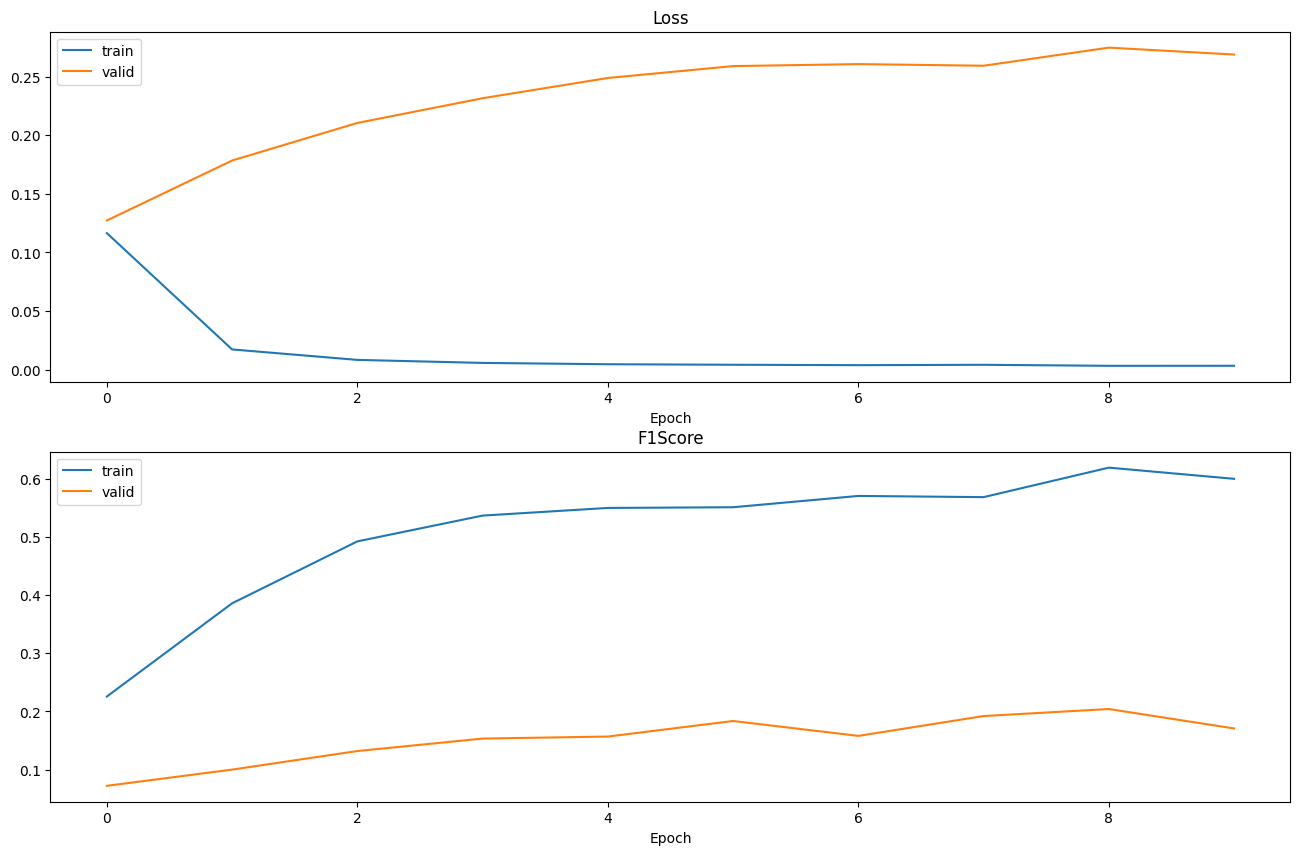

In [24]:
plot_learning_curve(history)

In [25]:
y_pred = (model.predict(X_test) > 0.5).astype(int)

y_test_neutral = np.all(y_test == 0, axis=1).astype(int)
y_pred_neutral = np.all(y_pred == 0, axis=1).astype(int)

y_test_tmp = np.hstack([y_test,y_test_neutral.reshape(-1,1)])
y_pred_tmp = np.hstack([y_pred,y_pred_neutral.reshape(-1,1)])

print(classification_report(y_test_tmp,y_pred_tmp,target_names = ["toxic","severe_toxic","obscene","threat",\
                                                    "insult","identity_hate","neutral"]))

998/998 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step
               precision    recall  f1-score   support

        toxic       0.70      0.69      0.70      3049
 severe_toxic       0.33      0.31      0.32       321
      obscene       0.72      0.76      0.74      1739
       threat       0.33      0.22      0.27       103
       insult       0.63      0.59      0.61      1605
identity_hate       0.37      0.31      0.34       289
      neutral       0.97      0.96      0.97     28637

    micro avg       0.91      0.90      0.90     35743
    macro avg       0.58      0.55      0.56     35743
 weighted avg       0.91      0.90      0.90     35743
  samples avg       0.93      0.92      0.92     35743

